# Imports and Data Generation

In [10]:
import numpy as np
import optuna
import math
import random

N = 1024
data = list(range(N))

def sample_query_index():
    """Skewed toward low indices."""
    u = random.random()
    if u < 0.9:
        # 90% of the time, pick from first quarter
        return random.randint(0, N // 4 - 1)
    else:
        # 10% of the time, pick from remaining 3/4
        return random.randint(N // 4, N - 1)

# Quick sanity check
samples = [sample_query_index() for _ in range(10000)]
print("Approx mean index:", sum(samples) / len(samples))


Approx mean index: 178.5646


# Binary Search With Tunable Ratio

In [11]:
def binary_search_with_ratio(arr, target, ratio):
    """
    arr: sorted list
    target: value to find
    ratio: hyperparameter in (0, 1), controls where we split the interval
    Returns: (found, num_comparisons)
    """
    low = 0
    high = len(arr) - 1
    comparisons = 0

    # Safety: keep ratio away from exactly 0 or 1
    ratio = max(0.01, min(0.99, ratio))

    while low <= high:
        # Compute mid using the ratio
        mid = low + int((high - low) * ratio)
        mid = max(low, min(mid, high))

        comparisons += 1
        if arr[mid] == target:
            return True, comparisons
        elif arr[mid] < target:
            low = mid + 1
        else:
            high = mid - 1

    return False, comparisons


# Objective Function

In [12]:
def average_comparisons_for_ratio(ratio, num_trials=2000):
    total_comparisons = 0
    for _ in range(num_trials):
        idx = sample_query_index()
        target = data[idx]
        found, comps = binary_search_with_ratio(data, target, ratio)
        total_comparisons += comps
    return total_comparisons / num_trials

# Quick test for a couple of ratios
for r in [0.3, 0.5, 0.7]:
    avg = average_comparisons_for_ratio(r, num_trials=1000)
    print(f"ratio={r:.2f}, avg comparisons={avg:.3f}")


ratio=0.30, avg comparisons=9.191
ratio=0.50, avg comparisons=8.984
ratio=0.70, avg comparisons=11.368


# Visualize the Hidden Function

Best ratio from grid search ≈ 0.383, avg comps=8.736


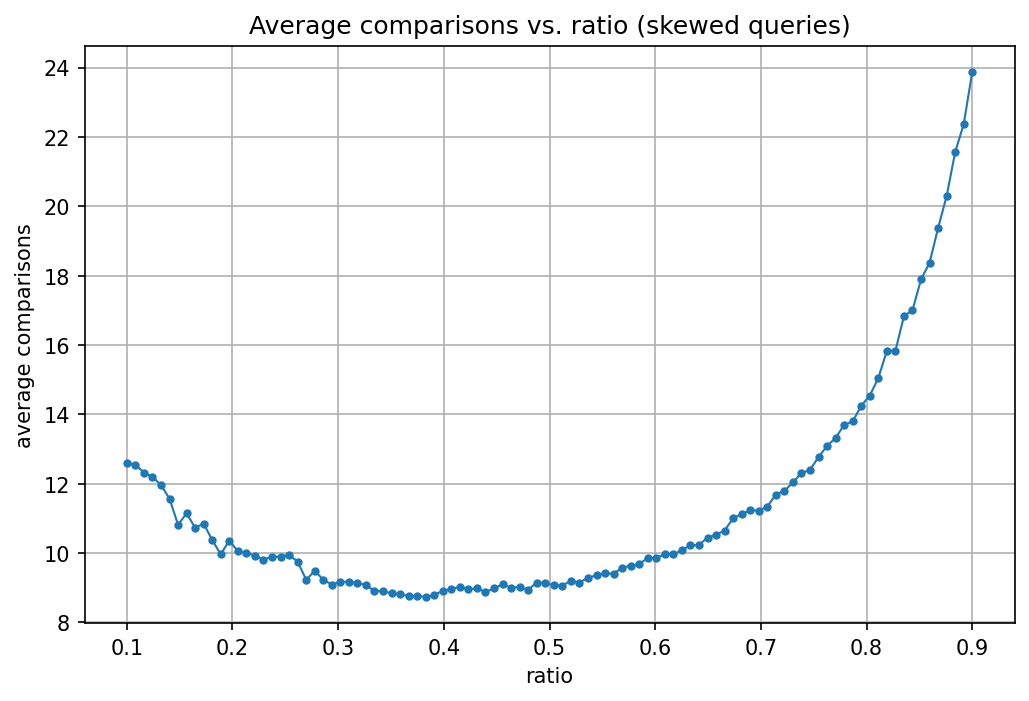

In [13]:
import matplotlib.pyplot as plt

ratios = np.linspace(0.1, 0.9, 100)
avg_comps = [average_comparisons_for_ratio(r, num_trials=1000) for r in ratios]

plt.figure(figsize=(8, 5), dpi=150)
plt.plot(ratios, avg_comps, marker='o',markersize=3, linewidth=1)
plt.xlabel("ratio")
plt.ylabel("average comparisons")
plt.title("Average comparisons vs. ratio (skewed queries)")
plt.grid(True)

best_idx = int(np.argmin(avg_comps))
print(f"Best ratio from grid search ≈ {ratios[best_idx]:.3f}, avg comps={avg_comps[best_idx]:.3f}")


# Hyper Parameter Tune with Bayesian Optimization

In [14]:
def objective(trial):
    # Sample ratio in (0.1, 0.9) to avoid edge pathologies
    ratio = trial.suggest_float("ratio", 0.1, 0.9)
    avg_comp = average_comparisons_for_ratio(ratio, num_trials=1000)
    return avg_comp  # we want to minimize this

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # you can increase this later

print("Best trial:")
best_trial = study.best_trial
print("  value (avg comparisons):", best_trial.value)
print("  params:", best_trial.params)


[I 2025-11-20 07:41:16,135] A new study created in memory with name: no-name-4a0096b0-2744-494f-bfca-805eb38ba3d4
[I 2025-11-20 07:41:16,138] Trial 0 finished with value: 11.354 and parameters: {'ratio': 0.6941681932837259}. Best is trial 0 with value: 11.354.
[I 2025-11-20 07:41:16,140] Trial 1 finished with value: 12.331 and parameters: {'ratio': 0.10951366679884639}. Best is trial 0 with value: 11.354.
[I 2025-11-20 07:41:16,143] Trial 2 finished with value: 9.136 and parameters: {'ratio': 0.5231968241888852}. Best is trial 2 with value: 9.136.
[I 2025-11-20 07:41:16,145] Trial 3 finished with value: 15.045 and parameters: {'ratio': 0.8095476401112526}. Best is trial 2 with value: 9.136.
[I 2025-11-20 07:41:16,148] Trial 4 finished with value: 9.657 and parameters: {'ratio': 0.580841719609999}. Best is trial 2 with value: 9.136.
[I 2025-11-20 07:41:16,150] Trial 5 finished with value: 8.983 and parameters: {'ratio': 0.4139548468554334}. Best is trial 5 with value: 8.983.
[I 2025-11-

Best trial:
  value (avg comparisons): 8.702
  params: {'ratio': 0.37929066927608046}


In [15]:
best_ratio = best_trial.params["ratio"]
grid_best_ratio = ratios[best_idx]

print(f"Grid best ratio: {grid_best_ratio:.3f}")
print(f"Optuna best ratio: {best_ratio:.3f}")
print(f"Midpoint ratio (0.5) avg comps:",
      average_comparisons_for_ratio(0.5, num_trials=2000))
print(f"Optuna best ratio avg comps:",
      average_comparisons_for_ratio(best_ratio, num_trials=2000))


Grid best ratio: 0.383
Optuna best ratio: 0.379
Midpoint ratio (0.5) avg comps: 8.9795
Optuna best ratio avg comps: 8.753
